# Utils

In [9]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
from my_functions import *

# Naive Bayes

In [2]:
class NaiveBayes:

    def _likelihood(self, x:float, mean:float, std:float) -> float:
        if std == 0:
            return 1
        z = -(((x - mean) / std)**2)/2
        pi = math.pi
        return  math.exp(z) / (math.sqrt(2*pi)*std)

    def _likelihood_multivariate(self, x_vec:np.array, mean_vec:np.array, cov:np.array) -> float:
        x_vec = np.atleast_2d(x_vec)
        mean_vec = np.atleast_2d(mean_vec)
        cov = np.atleast_2d(cov)

        n = len(x_vec)
        x_m = x_vec - mean_vec

        part1 = 1 / ((2*math.pi)**(n/2) * np.linalg.det(cov)**(1/2))
        # part2 = math.exp(-1/2*(np.linalg.solve(cov, x_m).T.dot(x_m)))
        part2 = math.exp(1/2*(x_m.T @ np.linalg.inv(cov) @ x_m))

        return part1 * part2
    
    def _ln(self, x):
        return math.log2(x + 0.00000001)

    def fit(self, X:pd.DataFrame, y:list):
        X['label'] = y
        # Compute prior, P(label)
        self.prior = {}
        self.unique_labels = X['label'].unique()
        for u_label in self.unique_labels:
            number_of_u_labels = len(X[X['label'] == u_label])
            self.prior[u_label] = number_of_u_labels / len(X)
        # Compute mean and standard deviation
        # for each paer <label> <feature>
        self.label_feat = {}
        for u_label in self.unique_labels:
            u_label_els = X[X['label'] == u_label]
            self.label_feat[u_label] = {}
            for feat in X.columns[:-1]:
                self.label_feat[u_label][feat] ={
                    'mean': compute_mean(u_label_els[feat]),
                    'std': compute_standard_deviation(u_label_els[feat])
                }

    def predict(self, X:pd.DataFrame):
        predictions = []
        x_columns = X.columns
        for x_values in X.values:
            # Compute the probability
            great_p = -math.inf
            prediction = ''
            # for each unique label
            for u_label in self.unique_labels:
                p = self._ln(self.prior[u_label])
                for i, value in enumerate(x_values):
                    feat = x_columns[i]
                    label_feat = self.label_feat[u_label][feat]
                    mean = label_feat['mean']
                    std = label_feat['std']
                    p += self._ln(self._likelihood(value, mean, std))
                # check if is the greatest probability
                if p > great_p:
                    # if so store
                    great_p = p
                    prediction = u_label
            # store prediction
            predictions.append(prediction)
        return predictions

    def plot_pdf(self, data:pd.DataFrame, label_column:str):
        # train the model
        self.fit(data.drop(columns=[label_column]), list(data[label_column]))

        feats = data.drop(columns=[label_column]).columns
        u_labels = data[label_column].unique()

        for feat in feats:
            line_data = { 'Label': [], 'X': [], 'Y': [], }
            scatter_data = { 'Label': [], 'X': [], 'Y': [], }
            for i_label, label in enumerate(u_labels):
                mean = self.label_feat[label][feat]['mean']
                std = self.label_feat[label][feat]['std']
                max_value = max(data[feat])
                for x in np.arange(0, max_value, 0.001):
                    line_data['Label'].append(label)
                    line_data['X'].append(x)
                    line_data['Y'].append(self._likelihood(x, mean, std))
                label_data = data[data[label_column] == label]
                scatter_data['Label'] += [label for _ in range(len(label_data))]
                scatter_data['X'] += list(label_data[feat])
                scatter_data['Y'] += [i_label for _ in range(len(label_data))]
            plt.title(feat)
            line = sns.lineplot(data=line_data, x='X', y='Y', hue='Label')
            scatter = sns.scatterplot(data=scatter_data, x='X', y='Y', hue='Label')
            sns.move_legend(scatter, "upper left", bbox_to_anchor=(1, 1))
            plt.show()

    def plot_pdf_3D(self, df:pd.DataFrame, label_column:str):
        # train the model
        df_without_label = df.drop(columns=[label_column])
        df_cov = df_without_label.values
        self.fit(df_without_label, list(df[label_column]))

        feats = df_without_label.columns
        u_labels = df[label_column].unique()

        for i1 in range(len(feats)-1):
            for i2 in range(i1+1, len(feats)-1):
                feat_1 = feats[i1]
                feat_2 = feats[i2]
                for i_label, label in enumerate(u_labels):
                    mean_1 = self.label_feat[label][feat_1]['mean']
                    min_value_1 = min(df[feat_1])
                    max_value_1 = max(df[feat_1])
                    mean_2 = self.label_feat[label][feat_2]['mean']
                    min_value_2 = min(df[feat_2])
                    max_value_2 = max(df[feat_2])
                    N = 0.1
                    X = np.arange(min_value_1, max_value_1, N)
                    Y = np.arange(min_value_2, max_value_2, N)
                    X, Y = np.meshgrid(X, Y)
                    Z = np.empty(X.shape)
                    mu = np.array([[mean_1], [mean_2]])
                    Sigma = compute_covariance_matrix(df_cov)
                    for i in range(Z.shape[0]):
                        for j in range(Z.shape[1]):
                            x = np.array([[X[i][j]],[Y[i][j]]])
                            Z[i][j] = self._likelihood_multivariate(x, mu, Sigma)
                    
                    ax = plt.axes(projection='3d')
                    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                                    cmap='viridis', edgecolor='none')
                    ax.set_title(label)
                    ax.set_xlabel(feat_1)
                    ax.set_ylabel(feat_2)
                    ax.set_zlabel('Discriminant')
                    plt.show()
                    


In [3]:
# Download Iris data
download_file('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')

In [4]:
# Load dataset as a pandas DataFrame
iris_column_names = ['Sepal_Length', 'Sepal_Width','Petal_Length', 'Petal_Width', 'Class']
iris = pd.read_csv('./datasets/iris.data', names=iris_column_names, sep=',')
iris.head(2)

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


In [5]:
# Normalize dataset (0 - 1)
features = iris.columns[:-1]
iris = normalize_data(iris, features)

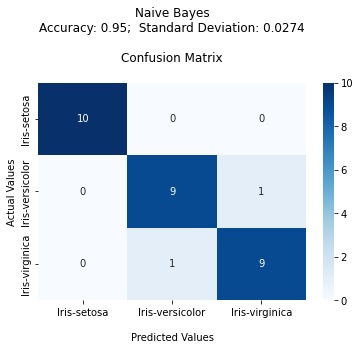

In [6]:
# Compute a confusion matrix or "matriz de confusão"
plot_acc_std_closest_cm_to_the_mean(iris, 'Class', NaiveBayes, [], 'Naive Bayes')

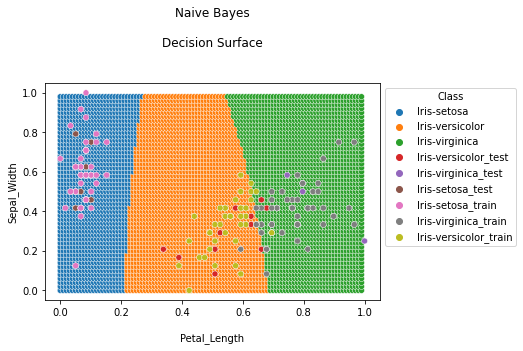

In [8]:
# Compute decision boundary or Decision Surface or "Superfície de decisão"
selected_feats = ['Petal_Length','Sepal_Width']
label_column = 'Class'
df = decision_surface(NaiveBayes(), iris, selected_feats, label_column)
plot_scatter(df, selected_feats, label_column, 'Naive Bayes\n\nDecision Surface')

# Coluna Dataset

In [10]:
# Download Coluna dataset
download_file('https://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip')
# unzip the vertebral_column_data file
os.system('sudo apt install unzip & unzip vertebral_column_data.zip')

1

In [11]:
# Load dataset as a pandas DataFrame
coluna_features = [
'pelvic_incidence',
'pelvic_tilt',
'lumbar_lordosis_angle',
'sacral_slope',
'pelvic_radius',
'degree_spondylolisthesis',
'label'
]
coluna = pd.read_csv('./datasets/column_3C.dat',  sep=' ', names=coluna_features, header=None)
coluna.head(2)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,label
0,63.03,22.55,39.61,40.48,98.67,-0.25,DH
1,39.06,10.06,25.02,29.00,114.41,4.56,DH


In [12]:
# Normalize dataset (0 - 1)
features = coluna.columns[:-1]
normalize_data(coluna, features)
coluna.head(2)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,label
0,0.355710,0.519829,0.229193,0.250879,0.307452,0.025163,DH
1,0.124518,0.296713,0.098622,0.144642,0.476718,0.036359,DH


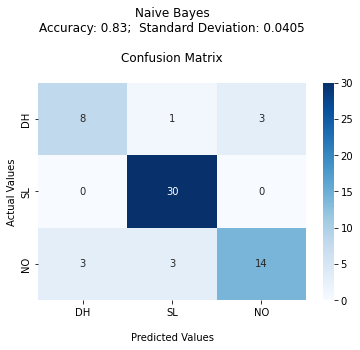

In [13]:
# Compute a confusion matrix or "matriz de confusão"
plot_acc_std_closest_cm_to_the_mean(coluna, 'label', NaiveBayes, [], 'Naive Bayes')

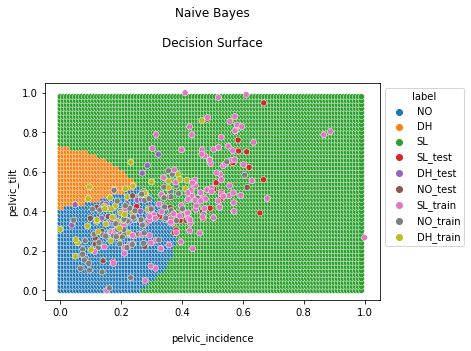

In [16]:
label_column = 'label'
selected_feats = compute_selected_feats(coluna, label_column)
df = decision_surface(NaiveBayes(), coluna, selected_feats, label_column)
plot_scatter(df, selected_feats, label_column, 'Naive Bayes\n\nDecision Surface')

# Breast Cancer Wisconsin (Diagnostic) Data Set

In [24]:
download_file('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data')

In [25]:
wdbc_column_names = [
    "id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst",
]
breast_cancer_wisconsin = pd.read_csv('./datasets/wdbc.data', names=wdbc_column_names, sep=',')
breast_cancer_wisconsin = breast_cancer_wisconsin.drop(columns=['id'])
breast_cancer_wisconsin.head(2)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [26]:
label_column = 'diagnosis'
# Normalize dataset
features = breast_cancer_wisconsin.drop(columns=[label_column]).columns
breast_cancer_wisconsin = normalize_data(breast_cancer_wisconsin, features)
breast_cancer_wisconsin.head(2)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,M,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878


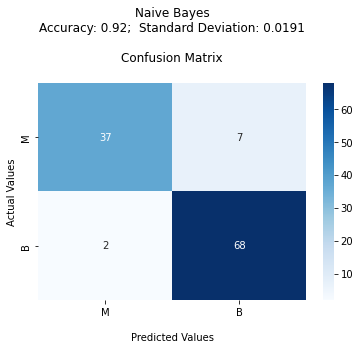

In [27]:
dataset = breast_cancer_wisconsin
# Compute a confusion matrix or "matriz de confusão"
plot_acc_std_closest_cm_to_the_mean(dataset, label_column, NaiveBayes, [], 'Naive Bayes')

In [28]:
# Get the two feats, with the most high Eigenvalues, of the Dataset
selected_feats = compute_selected_feats(dataset, label_column)

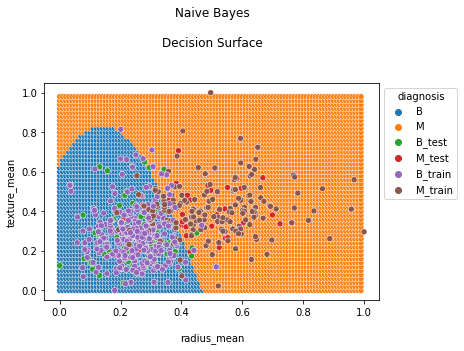

In [29]:
# Compute decision boundary or Decision Surface or "Superfície de decisão"
df = decision_surface(NaiveBayes(), dataset, selected_feats, label_column)
plot_scatter(df, selected_feats, label_column, 'Naive Bayes\n\nDecision Surface')

# Dermatology Dataset

In [30]:
download_file('https://archive.ics.uci.edu/ml/machine-learning-databases/dermatology/dermatology.data')

In [31]:
dermatology_column_names = [
      'erythema',
      'scaling',
      'definite borders',
      'itching',
      'koebner phenomenon',
      'polygonal papules',
      'follicular papules',
      'oral mucosal involvement',
      'knee and elbow involvement',
      'scalp involvement',
      'family history',
      'melanin incontinence',
      'eosinophils in the infiltrate',
      'PNL infiltrate',
      'fibrosis of the papillary dermis',
      'exocytosis',
      'acanthosis',
      'hyperkeratosis',
      'parakeratosis',
      'clubbing of the rete ridges',
      'elongation of the rete ridges',
      'thinning of the suprapapillary epidermis',
      'spongiform pustule',
      'munro microabcess',
      'focal hypergranulosis',
      'disappearance of the granular layer',
      'vacuolisation and damage of basal layer',
      'spongiosis',
      'saw-tooth appearance of retes',
      'follicular horn plug',
      'perifollicular parakeratosis',
      'inflammatory monoluclear inflitrate',
      'band-like infiltrate',
      'Age',
      'Class',
]
dermatology = pd.read_csv('./datasets/dermatology.data', names=dermatology_column_names, sep=',')
dermatology.head(2)

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,...,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,Class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1


In [32]:
label_column = 'Class'
missing_value = '?'
# Replacing missing values by the mean
unique_values = list(dermatology['Age'].unique())
unique_values.remove(missing_value)
mean_without_misses  = compute_mean(dermatology['Age'].filter(items=unique_values))
dermatology['Age'] = dermatology['Age'].apply(lambda v: mean_without_misses if v == missing_value else float(v))

In [33]:
# Normalize dataset
features = dermatology.drop(columns=[label_column]).columns
dermatology = normalize_data(dermatology, features)
dermatology.head(2)

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,...,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,Class
0,0.666667,0.666667,0.0,1.000000,0.000000,0.0,0.0,0.0,0.333333,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.333333,0.0,0.733333,2
1,1.000000,1.000000,1.0,0.666667,0.333333,0.0,0.0,0.0,0.333333,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.106667,1


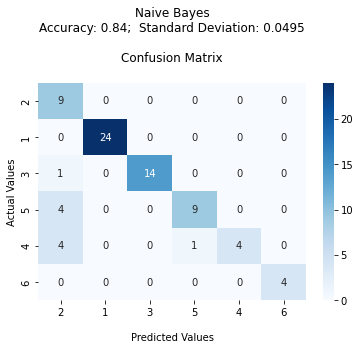

In [35]:
# Compute a confusion matrix or "matriz de confusão"
plot_acc_std_closest_cm_to_the_mean(dermatology, label_column, NaiveBayes, [], 'Naive Bayes')

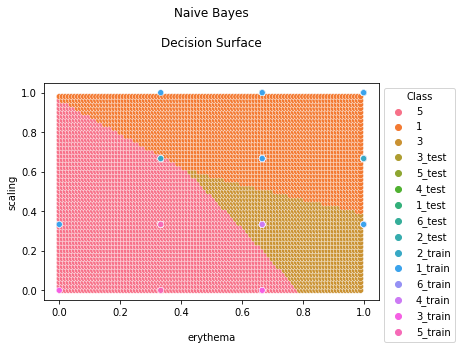

In [36]:

selected_feats = compute_selected_feats(dermatology, label_column)
df = decision_surface(NaiveBayes(), dermatology, selected_feats, label_column)
plot_scatter(df, selected_feats, label_column, 'Naive Bayes\n\nDecision Surface')

# Artifical Dataset

In [37]:
# Generate dataset
dataset_size = 150
noise = 0.1
centroid_size = int(dataset_size / 3)
classe1_size = centroid_size
classe2_size = centroid_size
classe3_size = centroid_size
c1_centroids = [
    [0.25, 0.75],
]
c2_centroids = [
    [0.75, 0.75],
]
c3_centroids = [
    [0.50, 0.25],
]
x1, x2, label = [], [], []
for centroid in c1_centroids:
    for _ in range(classe1_size):
        noise1 = random.random() * noise - noise / 2
        noise2 = random.random() * noise - noise / 2
        x1.append(centroid[0] + noise1)
        x2.append(centroid[1] + noise2)
        label.append('classe_1')
for centroid in c2_centroids:
    for _ in range(classe2_size):
        noise1 = random.random() * noise - noise / 2
        noise2 = random.random() * noise - noise / 2
        x1.append(centroid[0] + noise1)
        x2.append(centroid[1] + noise2)
        label.append('classe_2')
for centroid in c3_centroids:
    for _ in range(classe3_size):
        noise1 = random.random() * noise - noise / 2
        noise2 = random.random() * noise - noise / 2
        x1.append(centroid[0] + noise1)
        x2.append(centroid[1] + noise2)
        label.append('classe_3')

In [38]:
artificial_dataset = pd.DataFrame({
    'feature_1': x1,
    'feature_2': x2,
    'label': label
})
artificial_dataset.head(3)

,feature_1,feature_2,label
0,0.214756,0.781981,classe_1
1,0.209162,0.787738,classe_1
2,0.251703,0.737164,classe_1


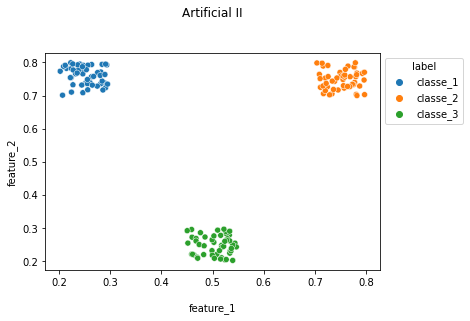

In [39]:
plot_scatter(artificial_dataset, artificial_dataset.columns[:-1], artificial_dataset.columns[-1], 'Artificial II')

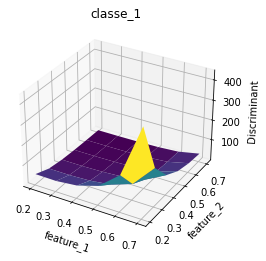

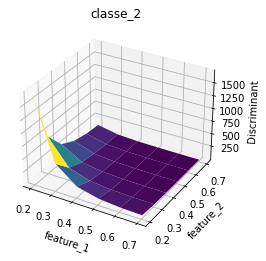

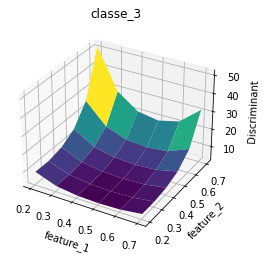

In [40]:
model = NaiveBayes()
model.plot_pdf_3D(artificial_dataset, 'label')

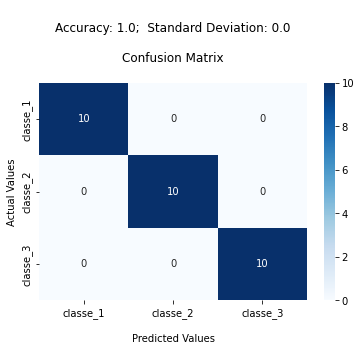

In [41]:
dataset = artificial_dataset
label_column = 'label'
# Compute a confusion matrix or "matriz de confusão"
plot_acc_std_closest_cm_to_the_mean(dataset, label_column, NaiveBayes)

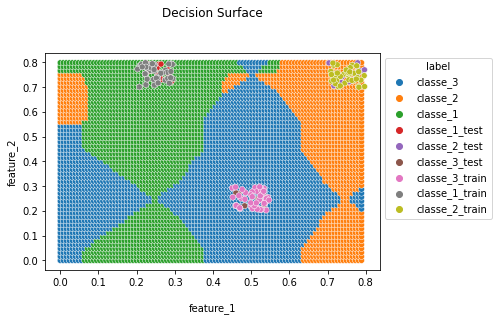

In [42]:
selected_feats = artificial_dataset.columns[:-1]
df = decision_surface(NaiveBayes(), dataset, selected_feats, label_column)
plot_scatter(df, selected_feats, label_column, 'Decision Surface')